## Job Market Analysis Project
This project analyzes job market data to uncover trends, skills demand, and salary patterns using various Data Science and Machine Learning techniques.

**Objective:** Provide insights for job seekers and employers based on available datasets.

**Dataset:** Kaggle's job market dataset (2016) - later we will replace with 2023+ data.


## Problem statement

**Goal:** produce an actionable analysis of US job postings that (1) surfaces demand shifts in job roles and skills, and (2) models salary where reliable labels exist — with an explicit focus on reproducibility and temporal generalization.

**Business questions:**
- Which job titles, skills, and sectors were most in-demand in 2016?
- What salary patterns exist, and how predictable are salaries from job posting fields?
- What biases or limitations does the dataset contain that affect conclusions?

**Scope & approach:**  
We use EDA and NLP (title + description processing), then build regression models (baseline → tree-based) to predict salary. All modeling will use **time-aware validation** and careful label construction to avoid misleading results.

Data Sources:
* **2016:** [Monster.com Job Postings Dataset](https://www.kaggle.com/datasets/PromptCloudHQ/us-jobs-on-monstercom )  
* **2023:** [US Job Postings Dataset](https://www.kaggle.com/datasets/techmap/us-job-postings-from-2023-05-05?)  



## Data dictionary

| Column name | Type | Description |
|-------------|------|-------------|
| `job_id` | string | Unique identifier for the posting (if available) |
| `company` | string | Employer name |
| `title` | string | Job title from the posting |
| `location` | string | Full location string (city, state) |
| `description` | string | Full job description text |
| `salary` | string/var | Raw salary string as scraped (may be range, hourly, or missing) |
| `date_added` | datetime | Date the job was posted (or scraped) |
| `job_type` | string | Full-time/part-time/contract (if available) |
| `category` | string | Job category or industry tag (if available) |

**Notes:**  
- Some rows do not include salary information. We will create a derived numeric `salary_annual` and flags describing the salary source/type.  
- We will standardize `location` to `city, state` and create `state` and `is_remote` flags.


##Imports

In [198]:
# Install NLTK only if not available
try:
    import nltk
except ImportError:
    !pip install nltk

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [199]:
# Core EDA + preprocessing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud


### Initial data checks and EDA goals

Goals for this section:
1. Understand data shapes and missingness.
2. Detect labelling issues for salary (ranges, hourly, non-US currency).
3. Inspect distributions for title frequency, location, and salary (where available).


In [200]:
# Load data
df = pd.read_csv("monster_com-job_sample.csv", parse_dates=["date_added"], low_memory=False)

# View first 10 rows
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
display(df.head(10))  # show first 10 rows for better feel

Dataset contains 22000 rows and 14 columns.



,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
0,United States of America,US,NaT,No,jobs.monster.com,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,Full Time Employee,"Madison, WI 53702",NaN,http://jobview.monster.com/it-support-technici...,NaN,IT/Software Development,11d599f229a80023d2f40e7c52cd941e
1,United States of America,US,NaT,No,jobs.monster.com,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,Full Time,"Madison, WI 53708",Printing and Publishing,http://jobview.monster.com/business-reporter-e...,NaN,NaN,e4cbb126dabf22159aff90223243ff2a
2,United States of America,US,NaT,No,jobs.monster.com,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,"Full Time, Employee",DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,http://jobview.monster.com/senior-training-lea...,NaN,NaN,839106b353877fa3d896ffb9c1fe01c0
3,United States of America,US,NaT,No,jobs.monster.com,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,Full Time,"Dixon, CA",Altec Industries,http://jobview.monster.com/engineer-quality-jo...,NaN,Experienced (Non-Manager),58435fcab804439efdcaa7ecca0fd783
4,United States of America,US,NaT,No,jobs.monster.com,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,Full Time Employee,"Camphill, PA",Retail,http://jobview.monster.com/shift-supervisor-pa...,NaN,Project/Program Management,64d0272dc8496abfd9523a8df63c184c
5,United States of America,US,NaT,No,jobs.monster.com,Job Description Job #: 720298Apex Systems has...,Construction PM - Charlottesville Job in Charl...,Full Time Employee,"Charlottesville, VA",Computer/IT Services,http://jobview.monster.com/construction-pm-cha...,NaN,Experienced (Non-Manager),1e2637cb5f7a2c4615a99a26c0566c66
6,United States of America,US,NaT,No,jobs.monster.com,Report this job About the Job Based in San Fra...,CyberCoders Job Application for Principal QA E...,"Full Time, Employee",Contact name Tony Zerio,Computer Software,http://jobview.monster.com/principal-qa-engine...,NaN,NaN,455802d725fde67293970ab3953b1d39
7,United States of America,US,NaT,No,jobs.monster.com,RESPONSIBILITIES:Kforce has a client seeking a...,Mailroom Clerk Job in Austin,Full Time Employee,"Austin, TX 73301",NaN,http://jobview.monster.com/mailroom-clerk-job-...,NaN,Experienced (Non-Manager),549a0541e4452ecd155efc032aaa72d7
8,United States of America,US,NaT,No,jobs.monster.com,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,Part Time Employee,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,http://jobview.monster.com/housekeeper-job-aus...,NaN,Customer Support/Client Care,a6a2b5e825b8ce1c3b517adb2497c5ed
9,United States of America,US,NaT,No,jobs.monster.com,"Insituform Technologies, LLC, an Aegion compan...",Video Data Management /Transportation Technici...,NaN,"Chesterfield, MO",NaN,http://jobview.monster.com/video-data-manageme...,NaN,NaN,73a9ba2b706e02628fa22ca1357174b1


Columns with missing values: 5 / 14


,missing,pct
date_added,21878,99.45
salary,18554,84.34
organization,6867,31.21
sector,5194,23.61
job_type,1628,7.40


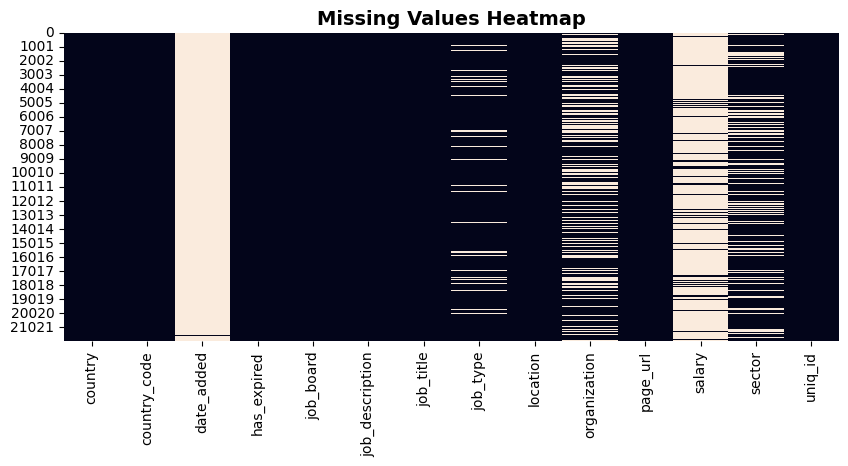

In [201]:
#Missing values analysis
missing = df.isnull().sum().sort_values(ascending=False)
missing_nonzero = missing[missing > 0]
print("Columns with missing values:", len(missing_nonzero), "/", df.shape[1])
display(missing_nonzero.to_frame("missing").assign(
    pct=lambda x: (x["missing"] / len(df) * 100).round(2)
))

plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap",fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()


In [202]:
#gain insight into the data
df.info()

print("\nSummary statistics for categorical columns:\n")
display(df.describe(include=[object]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   country          22000 non-null  object        
 1   country_code     22000 non-null  object        
 2   date_added       122 non-null    datetime64[ns]
 3   has_expired      22000 non-null  object        
 4   job_board        22000 non-null  object        
 5   job_description  22000 non-null  object        
 6   job_title        22000 non-null  object        
 7   job_type         20372 non-null  object        
 8   location         22000 non-null  object        
 9   organization     15133 non-null  object        
 10  page_url         22000 non-null  object        
 11  salary           3446 non-null   object        
 12  sector           16806 non-null  object        
 13  uniq_id          22000 non-null  object        
dtypes: datetime64[ns](1), object(13)
memor

,country,country_code,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
count,22000,22000,22000,22000,22000,22000,20372,22000,15133,22000,3446,16806,22000
unique,1,1,1,1,18744,18759,39,8423,738,22000,1737,163,22000
top,United States of America,US,No,jobs.monster.com,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,http://jobview.monster.com/Custodian-Lead-Job-...,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),1d37a888ca65fd919e459147a4c33457
freq,22000,22000,22000,22000,104,318,6757,646,1919,1,50,4594,1


**Findings:**

- Total rows in data: 22000
- Features with only 1 unique entry: country, country_code, has_expired, job_board.
- These features will not be able to help us determine anything about the job market or trends due to there being a lack of unique values. These columns will later be dropped when creating models

In [203]:
# Column types and missingness summary
print("\nColumn types:")
display(df.dtypes)



Column types:


,0
country,object
country_code,object
date_added,datetime64[ns]
has_expired,object
job_board,object
job_description,object
job_title,object
job_type,object
location,object
organization,object


Total columns with missing values: 5 / 14


,0
date_added,99.445455
salary,84.336364
organization,31.213636
sector,23.609091
job_type,7.400000
country,0.000000
job_description,0.000000
job_board,0.000000
has_expired,0.000000
country_code,0.000000


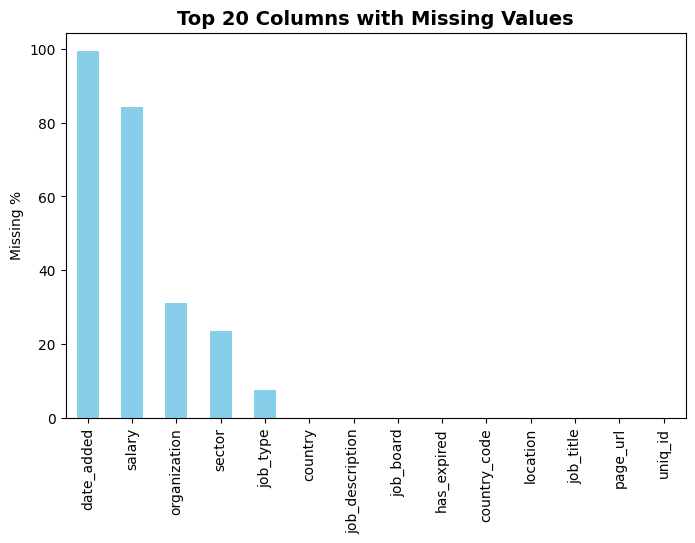

In [204]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print(f"Total columns with missing values: {(missing_pct > 0).sum()} / {df.shape[1]}")

# Display top 20
display(missing_pct.head(20))

# Optional: Visualize missingness
plt.figure(figsize=(8, 5))
missing_pct.head(20).plot(kind='bar', color='skyblue')
plt.ylabel("Missing %")
plt.title("Top 20 Columns with Missing Values",fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()



Findings:
- After understanding the data types, and percentage of data missing in each field, continue to inspect the data and prepare to clean and adjust data fields
- Based on the results above regarding the percentage of data missing in each field, the top missing features in the data are date_added, salary, and organization.
-The date_added column is not signifcant to this problem as we are not worried about when the job was posted we know this data was from the year 2016

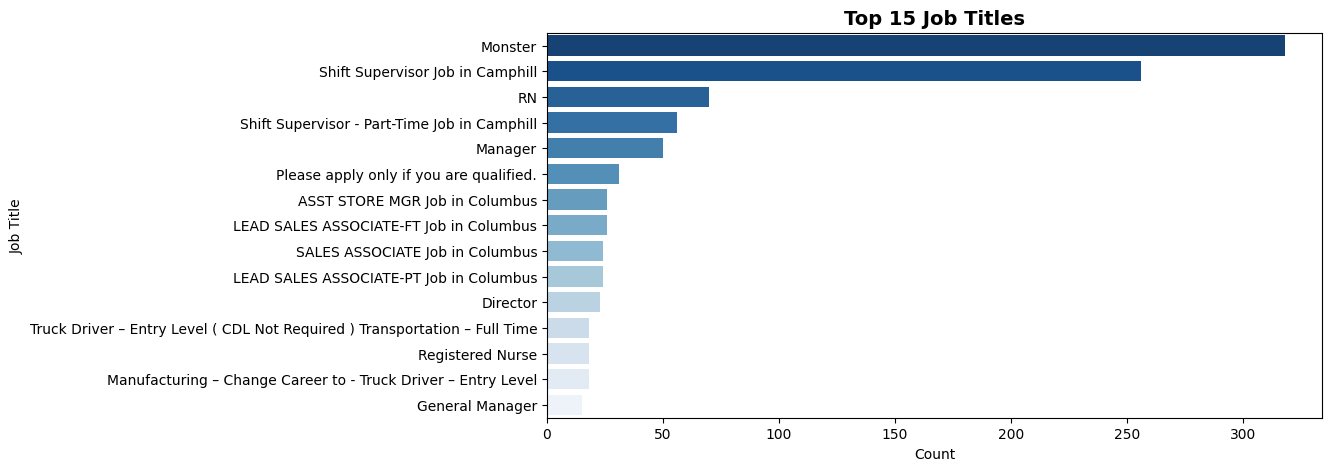


Top 10 companies:


,count
organization,
Healthcare Services,1919
All,1158
Retail,1081
Other/Not Classified,1048
Manufacturing - Other,885
Computer/IT Services,822
Legal Services,466
Business Services - Other,410
Restaurant/Food Services,384


In [205]:
# Basic counts for key fields
# After
top_jobs = df['job_title'].value_counts().head(15)
plt.figure(figsize=(10,5))
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette="Blues_r", hue = top_jobs.index, legend=False)
plt.title("Top 15 Job Titles",fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.show()


print("\nTop 10 companies:")
display(df['organization'].value_counts().head(10))



Posted date range: 2016-02-29 00:00:00 to 2017-01-16 00:00:00


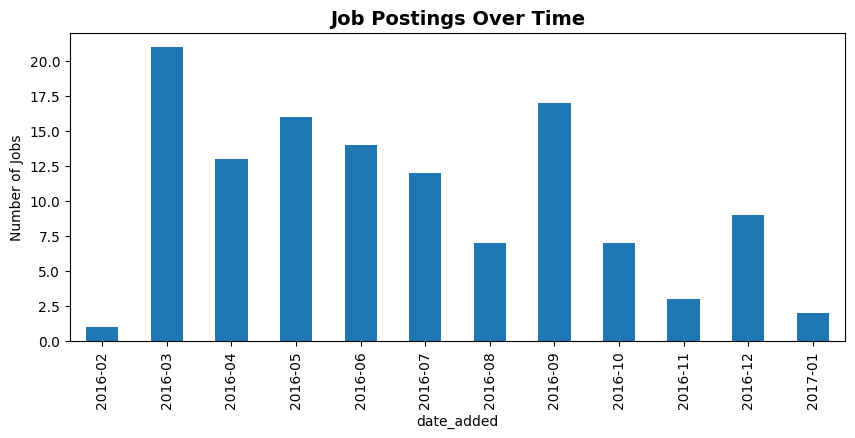

Salary column missing 84.34% of values.

Sample raw salary values:


,salary
17660,17.00 - 21.00 /hour
13812,"60,000.00 - 75,000.00 $ /yearDOE - Negotiable"
17394,BOE
17710,"$25,000.00+ /yearAdditional Spiffs"
8919,Commensurate with Experience
4386,"0.00 - 75,000.00 $ /year"
1745,"50,000.00 - 65,000.00 $ /year"
2566,"40,000.00 - 55,000.00 $ /year"
6921,"85,000.00 - 110,000.00 $ /year"
13463,"$65,000.00+ /year"


In [206]:
# If posted_date exists: show date range
if 'date_added' in df.columns:
    print("\nPosted date range:", df['date_added'].min(), "to", df['date_added'].max())

    plt.figure(figsize=(10,4))
    df['date_added'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
    plt.title("Job Postings Over Time",fontdict={'fontsize': 14, 'fontweight': 'bold'})
    plt.ylabel("Number of Jobs")
    plt.show()


# Quick salary raw sample for inspection
if 'salary' in df.columns:
    salary_missing_pct = df['salary'].isna().mean() * 100
    print(f"Salary column missing {salary_missing_pct:.2f}% of values.")
    print("\nSample raw salary values:")
    display(df['salary'].dropna().sample(min(10, len(df['salary'].dropna())), random_state=0))

else:
    print("\nNo salary column found.")

**Findings:**  
- Record percent missing for salary and any non-standard formats observed (ranges, hourly rates).   
- Note the top job titles and companies (high cardinality fields that may need aggregation).


**Findings:**

- Need to take a look at the features that directly relate to the outcome of the project, salary, job_type, organization and sector
- Since date_added is a field that is missing majority of values, we can fill with the year of 2016 and have that for all values or we can ignore creating visualizations and models that revolve around time.
- Salary and job_title will be major features we will look at as it shows the type of jobs in demand and the pay associated with those positions and we will be able to compare the fields and the average pay within the industries

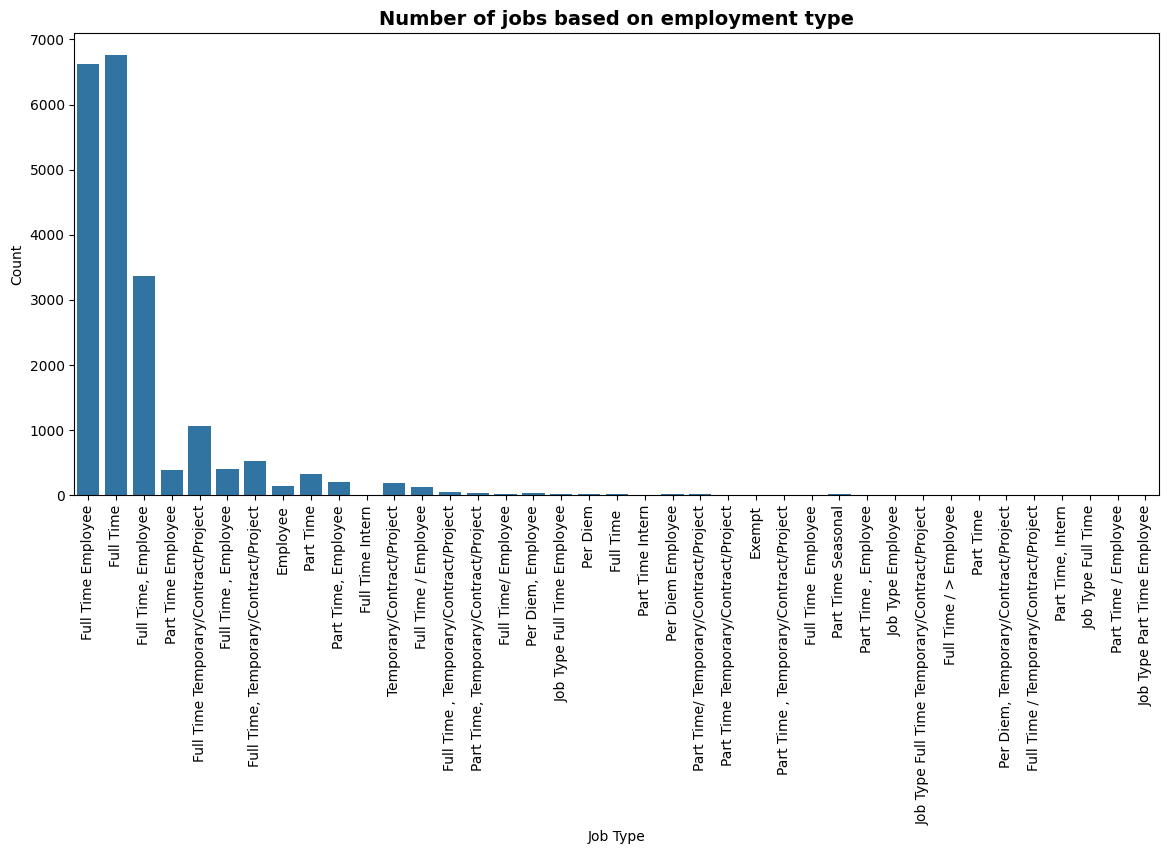

In [207]:
#Create plot based on employment types
plt.figure(figsize=(14,6))
sns.countplot(x='job_type', data=df)
plt.title('Number of jobs based on employment type', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Job Type')
plt.xticks(rotation=90)
plt.ylabel('Count')

plt.show()

**Findings:**

- Majority of the jobs being posted are Full Time positions with a small portion of positions being temporary or part time.

In [208]:
#Dropping columns that have no unique values
cols_to_drop = ['country', 'country_code', 'has_expired', 'job_board']
drop_existing = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=drop_existing, inplace=True)
print(f"Dropped columns: {drop_existing}")


Dropped columns: ['country', 'country_code', 'has_expired', 'job_board']


Drop missing rows in ['salary', 'sector', 'organization'] fields since if they are missing it won't help us achieve our goals outlined in the problem statement.

###Filtering Location to get Region

In [209]:
#take location and extract the state to create region feature
locations = df['location']
state_location = []
for x in range(len(locations)):

        if locations.get(x) != None:
                location = locations.get(x)
                location = str(location)
                area = location.split(',')
                state = area[len(area)-1]
                if(state[1:3].isupper()):
                        state_location.append(state[1:3])
                else:
                        state_location.append('N/A')
        else:
                state_location.append('N/A')

**Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

In [210]:
#create the state feature in the dataframe
df['state']= state_location

In [211]:
#Classify the states into their respective regions
state_regions = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West Coast',
    'CO': 'West', 'CT': 'Northeast', 'DE': 'South', 'FL': 'South', 'GA': 'South',
    'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'ME': 'Northeast', 'MD': 'South',
    'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest',
    'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest',
    'OK': 'South', 'OR': 'West Coast', 'PA': 'Northeast', 'RI': 'Northeast',
    'SC': 'South', 'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West',
    'VT': 'Northeast', 'VA': 'South', 'WA': 'West Coast', 'WV': 'South',
    'WI': 'Midwest', 'WY': 'West', 'DC': 'Northeast'
}

In [212]:
# Strip whitespace and make uppercase just in case
import re

# Extract the 2-letter state abbreviation using regex
df['state'] = df['location'].str.extract(r',\s*([A-Z]{2})\s*\d{0,5}')


# Map states to regions
df['region'] = df['state'].map(state_regions)

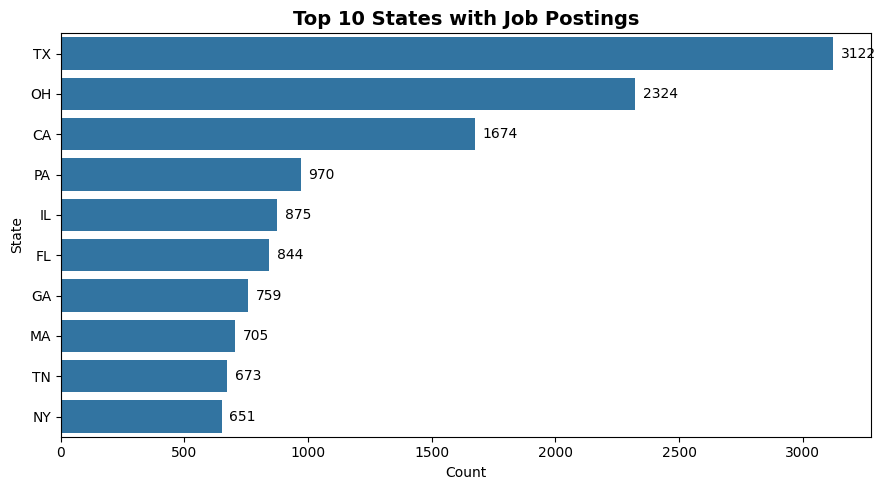

In [213]:
import re

def split_location(loc):
    if pd.isna(loc):
        return pd.Series([None, None])
    s = str(loc).strip()
    # If there's a comma, split as "City, ST"
    if "," in s:
        city, rest = s.split(",", 1)
        state_raw = rest.strip()
    else:
        city, state_raw = None, s  # handle formats like "TX 75201"
    # Extract 2-letter state code
    m = re.search(r"\b([A-Za-z]{2})\b", str(state_raw).upper())
    state = m.group(1).upper() if m else None
    city = None if city is None else city.strip()
    return pd.Series([city, state])

df[['city','state']] = df['location'].astype(str).apply(split_location)

def normalize_state(x):
    if pd.isna(x):
        return None
    x = str(x).strip().upper()
    m = re.match(r"^([A-Z]{2})", x)
    return m.group(1) if m else None

df['state'] = df['state'].apply(normalize_state)

valid_states = set("""AL AK AZ AR CA CO CT DE FL GA HI ID IL IN IA KS KY LA ME MD MA MI MN
MS MO MT NE NV NH NJ NM NY NC ND OH OK OR PA RI SC SD TN TX UT VT VA WA WV WI WY DC""".split())
df['state_clean'] = df['state'].where(df['state'].isin(valid_states))
top_states = df['state_clean'].value_counts().head(10)

plt.figure(figsize=(9, 5))
ax = sns.barplot(x=top_states.values, y=top_states.index)
ax.set_title("Top 10 States with Job Postings", fontsize=14, weight="bold")
ax.set_xlabel("Count")
ax.set_ylabel("State")

# Add value labels
for i, v in enumerate(top_states.values):
    ax.text(v + max(top_states.values)*0.01, i, str(int(v)), va='center')

plt.tight_layout()
plt.show()


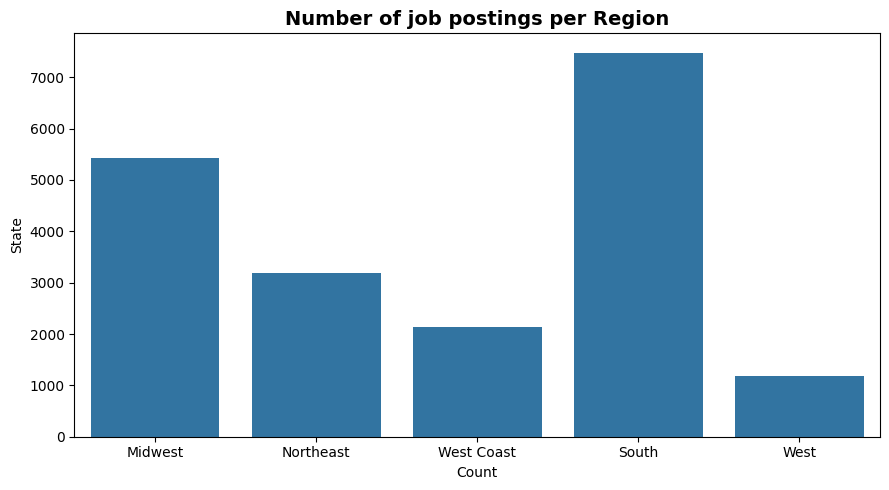

In [214]:
#Number of jobs based on region
plt.figure(figsize=(9, 5))
ax = sns.countplot(x='region', data = df)
ax.set_title("Number of job postings per Region", fontsize=14, weight="bold")
ax.set_xlabel("Count")
ax.set_ylabel("State")
plt.tight_layout()
plt.show()


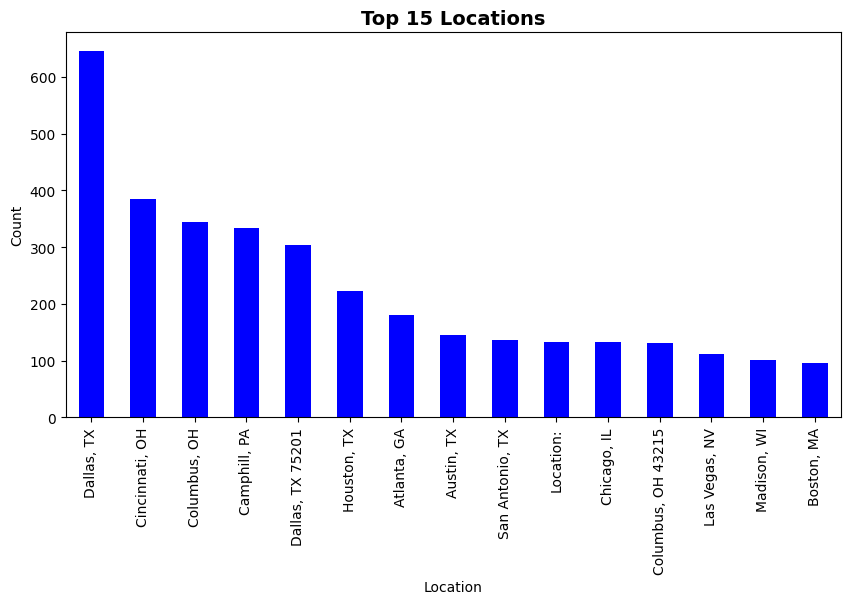

In [215]:
#Top locations posted
plt.figure(figsize=(10,5))
df['location'].value_counts().head(15).plot(kind='bar', color='blue')
plt.title("Top 15 Locations", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()


**Findings:**

- Most jobs posted were located in the South region.
- This could indicate that in the southern and midwestern regions employers use monster to post jobs and find job seekers.

###Filtering job_titles into job_category
I want to change this to check skills

In [216]:
#Taking the job_titles and extracting the field ex. tech, healthcare
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_title(title):
    words = word_tokenize(str(title).lower())
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmas)


In [217]:
#Extract specific titles and create a new field lemmatized_title
df['lemmatized_title'] = df['job_title'].apply(lemmatize_title)

In [218]:
#create job categories can be changed in future to expand for other jobs that might not be captured
job_categories = {
    'developer': 'Technology',
    'software': 'Technology',
    'engineer': 'Technology',
    'it': 'Technology',
    'data': 'Technology',
    'nurse': 'Healthcare',
    'health': 'Healthcare',
    'hospital': 'Healthcare',
    'medical': 'Healthcare',
    'teacher': 'Education',
    'professor': 'Education',
    'accountant': 'Finance',
    'finance': 'Finance',
    'analyst': 'Business',
    'manager': 'Business',
    'sales': 'Sales',
    'marketing': 'Marketing',
    'customer': 'Customer Service',
    'support': 'Customer Service',
    'warehouse': 'Logistics',
    'driver': 'Logistics',
    'mechanic': 'Trades',
    'construction': 'Trades',
    'electrician': 'Trades',
    'plumber': 'Trades',
    'recruiter': 'Human Resources',
    'hr': 'Human Resources',
    'lawyer': 'Legal',
    'attorney': 'Legal'
}


In [219]:
#mapping the lemmatized_title to job_category
def map_category(title):
    title = str(title).lower()
    for keyword, category in job_categories.items():
        if keyword in title:
            return category
    return 'Other'  # Default if no keyword matched

df['job_category'] = df['lemmatized_title'].apply(map_category)


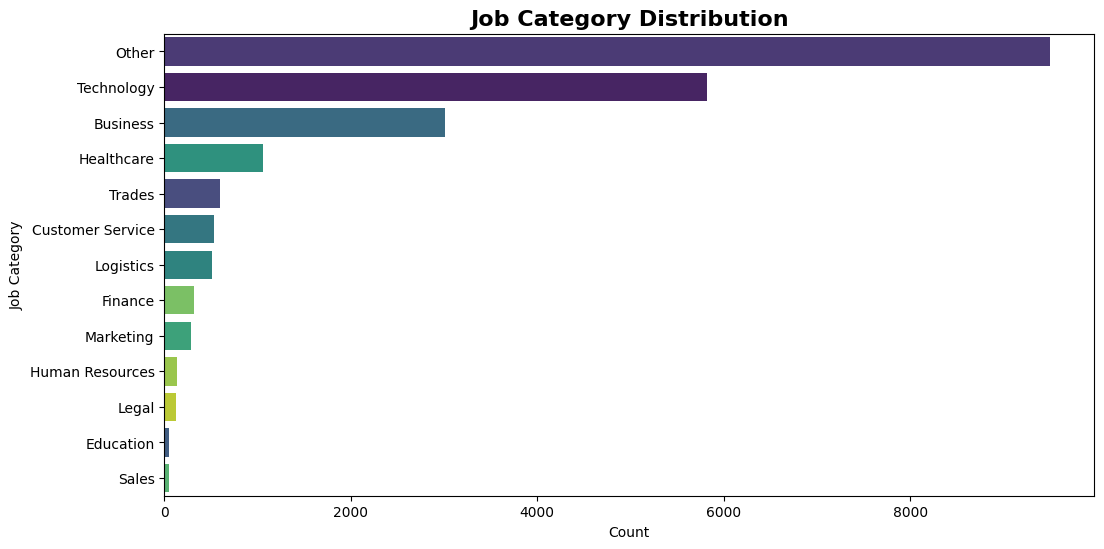

In [220]:
#plotting the count of job categories
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='job_category', order=df['job_category'].value_counts().index, palette='viridis', hue = 'job_category', legend=False)
plt.title('Job Category Distribution', fontdict={'fontsize': 16, 'fontweight': 'bold'} )
plt.xlabel('Count')
plt.ylabel('Job Category')
plt.show()


**Findings:**
- Based on the graph above most of the positions that could be classified were Technology and Business positions, with the least being in Human Resources, Sales, Legal, and Education.
- This could indicate a growing tech and business industry.
- Question: How long will these growing/booming industries last?

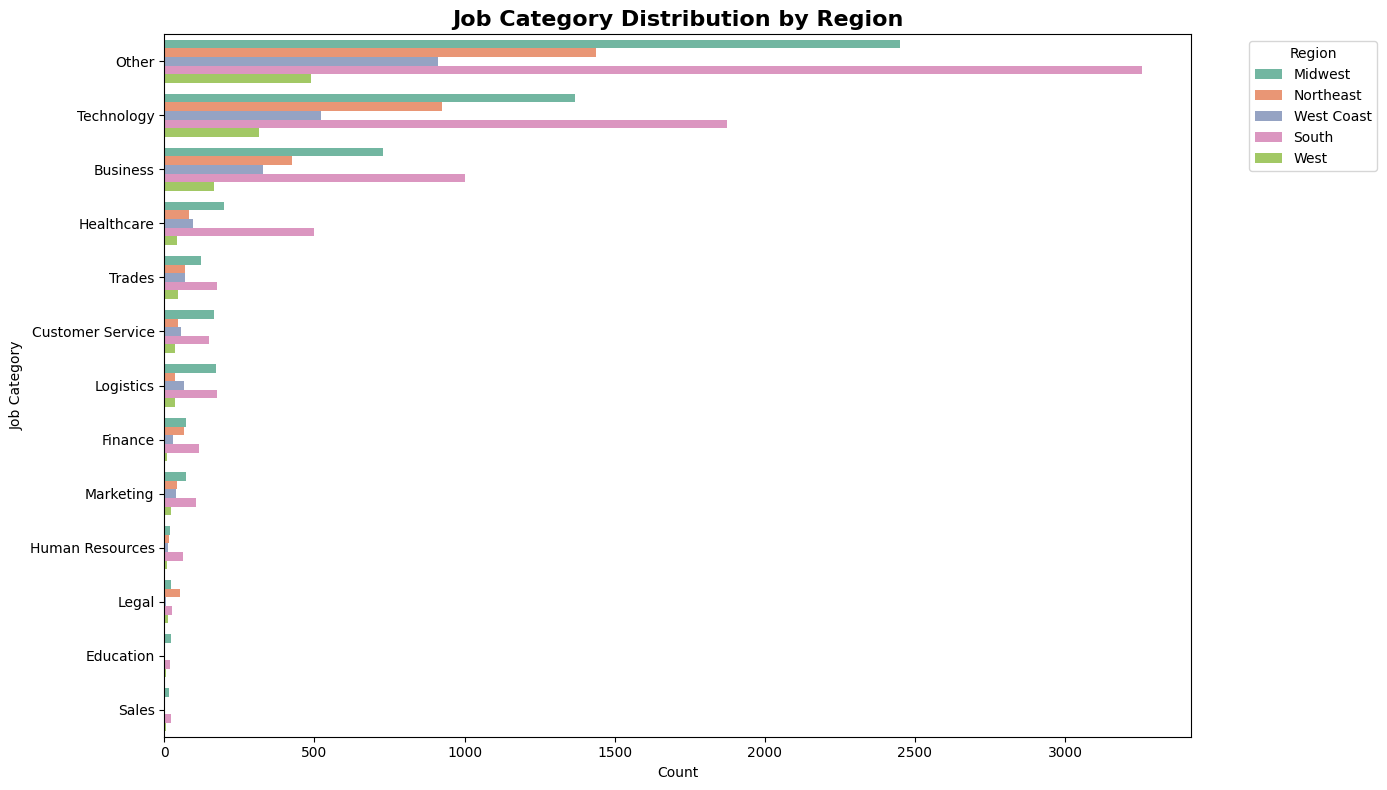

In [221]:
#number of jobs in each region based upon the job field
plt.figure(figsize=(14,8))
sns.countplot(data=df, y='job_category', hue='region', order=df['job_category'].value_counts().index, palette='Set2')
plt.title('Job Category Distribution by Region', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Count')
plt.ylabel('Job Category')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Findings:**

- While the Southern region has most of the job postings, the Midwestern region has more positions within the customer service, trades, logistics and sales industries.
- This can indicate a growth/developement in different regions. For example, the northeast is very established within the Tech and business fields, so they may not need to hire as many people as a growing or developing region such as the South.
- As a region develops, more people need to be hired to fill positions. Reasons a region may be developing could be from cost of business operating in other states. For example, cost of operating in California is more expensive than the cost of operating in Texas.

###Converting Salaries to all be average yearly salary

In [222]:
# Helper function to parse salary
def parse_salary(s):
    if pd.isna(s) or 'Not Specified' in s:
        return pd.Series([None, None, None])

    # Remove commas and dollar signs
    s_clean = s.replace(',', '').replace('$', '')

    # Match patterns like "50000 - 70000", "9.00 - 13.00", "60000/year"
    match = re.findall(r'(\d+(?:\.\d+)?)', s_clean)

    if len(match) == 1:
        min_sal = max_sal = float(match[0])
    elif len(match) >= 2:
        min_sal, max_sal = float(match[0]), float(match[1])
    else:
        return pd.Series([None, None, None])

    # Detect if it's hourly/monthly/yearly
    if 'hour' in s.lower():
        period = 'hour'
    elif 'month' in s.lower():
        period = 'month'
    else:
        period = 'year'

    return pd.Series([min_sal, max_sal, period])


In [223]:
#Parsing the salary from the dataframe
salary = df['salary'].apply(parse_salary)

In [224]:
#Get an idea of what the salaries look like
print(salary)

              0         1     2
0           NaN       NaN  None
1           NaN       NaN  None
2           NaN       NaN  None
3           NaN       NaN  None
4           NaN       NaN  None
...         ...       ...   ...
21995  120000.0  160000.0  year
21996   45000.0   60000.0  year
21997       NaN       NaN  None
21998      25.0      28.0  hour
21999   40000.0   46000.0  year

[22000 rows x 3 columns]


**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

In [225]:
#Creating separate columns for each of the pieces extracted
df['salary_min'] = salary[0]
df['salary_max'] = salary[1]
df['salary_means'] = salary[2]

**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

In [226]:
#Normalizing the salary data so that the data is consistent
def normalize_salary(row):
    if row['salary_means'] == 'hour':
        return row['salary_min'] * 2080, row['salary_max'] * 2080
    elif row['salary_means'] == 'month':
        return row['salary_min'] * 12, row['salary_max'] * 12
    else:
        return row['salary_min'], row['salary_max']



**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

In [227]:
#Creating new columns for yearly salary
df[['min_salary_yearly', 'max_salary_yearly']] = df.apply(normalize_salary, axis=1, result_type='expand')

**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

In [228]:
#Making salary bins for the visualizations
df['salary_bin'] = df['max_salary_yearly'] // 5000 * 5000  # bucket into $5k bins


**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

In [229]:
#Getting the top salary bins
salary_counts = df['salary_bin'].value_counts().sort_index()
bins = salary_counts.head(15)


**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

/tmp/ipython-input-2335418406.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bins.index.astype(int), y=bins.values, palette='viridis')


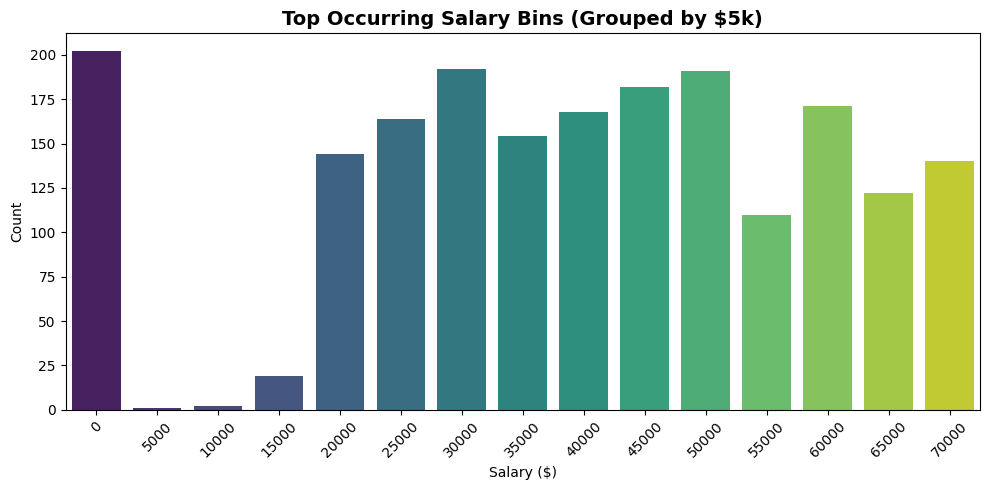

In [230]:
#Creating a plot of salary bins
plt.figure(figsize=(10, 5))
sns.barplot(x=bins.index.astype(int), y=bins.values, palette='viridis')
plt.title("Top Occurring Salary Bins (Grouped by $5k)", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Salary ($)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

A lot of the jobs did not have salaries posted with the position but for those that did the salaries range from 25,000 to 50,000

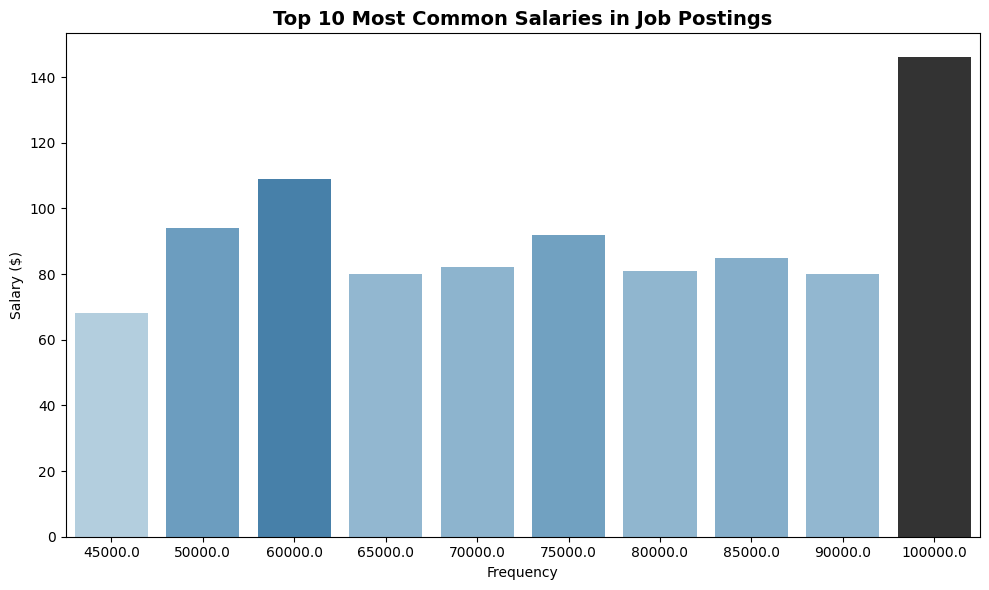

In [231]:
#visualize the top salaries
top_salaries = df['max_salary_yearly'].value_counts().nlargest(10)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_salaries.index, y=top_salaries, palette="Blues_d", hue = top_salaries, legend=False)
plt.xlabel("Frequency")
plt.ylabel("Salary ($)")
plt.title("Top 10 Most Common Salaries in Job Postings", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

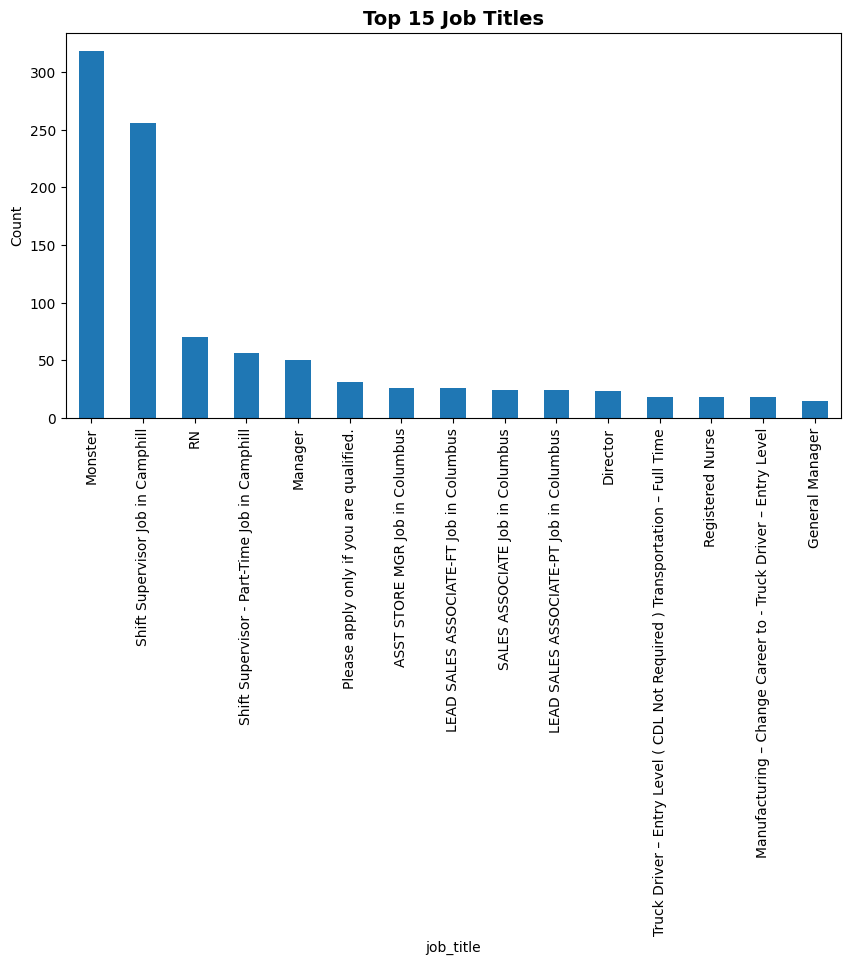

In [232]:
plt.figure(figsize=(10,5))
df['job_title'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Job Titles", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel("Count")
plt.show()


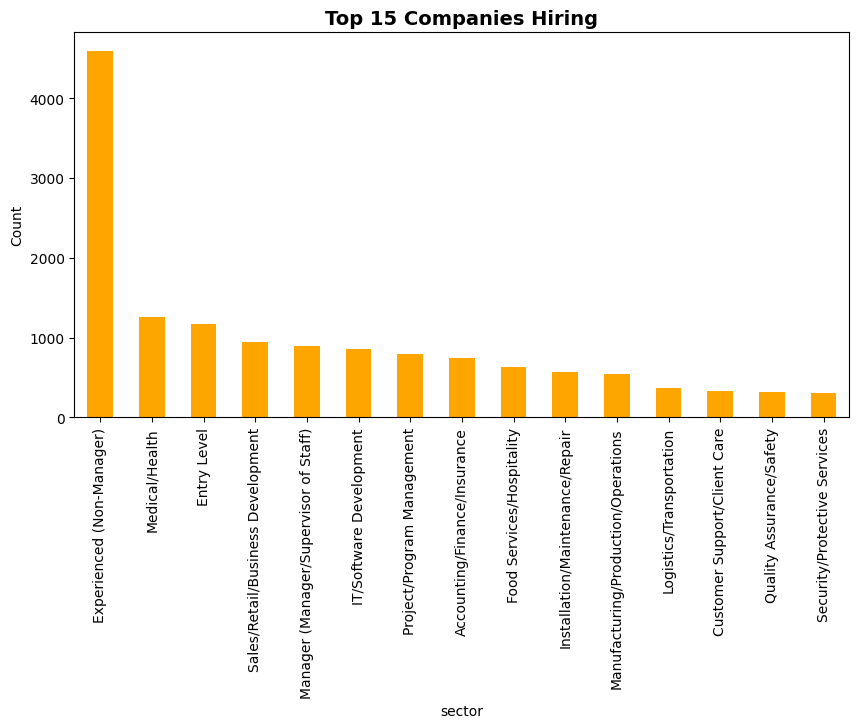

In [233]:
plt.figure(figsize=(10,5))
df['sector'].value_counts().head(15).plot(kind='bar', color='orange')
plt.title("Top 15 Companies Hiring", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel("Count")
plt.show()


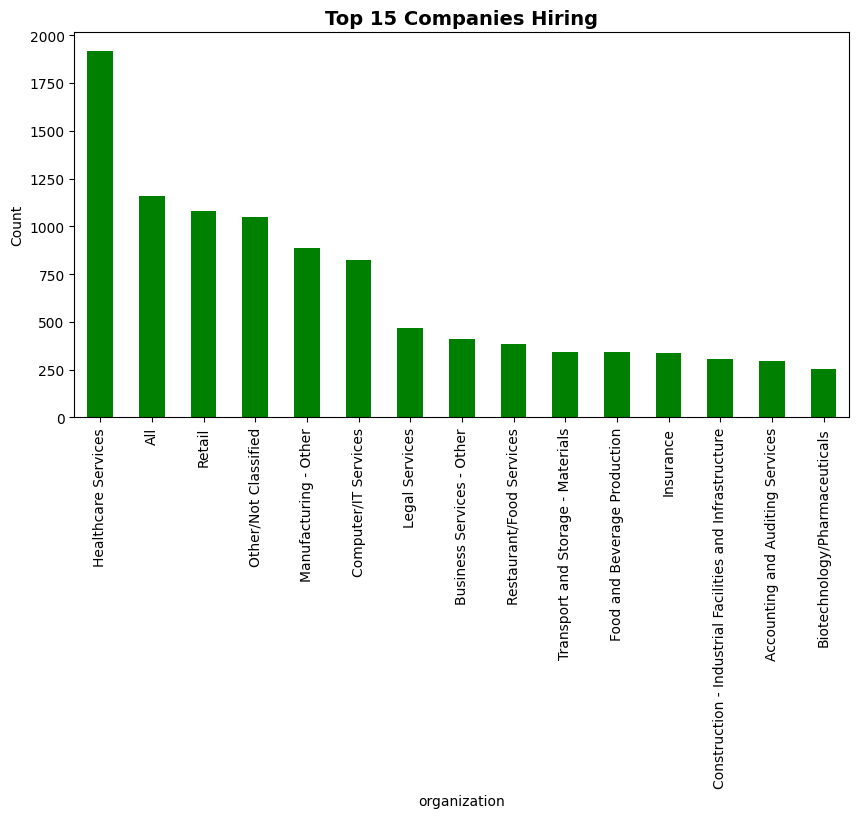

In [234]:
plt.figure(figsize=(10,5))
df['organization'].value_counts().head(15).plot(kind='bar', color='green')
plt.title("Top 15 Companies Hiring", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel("Count")
plt.show()

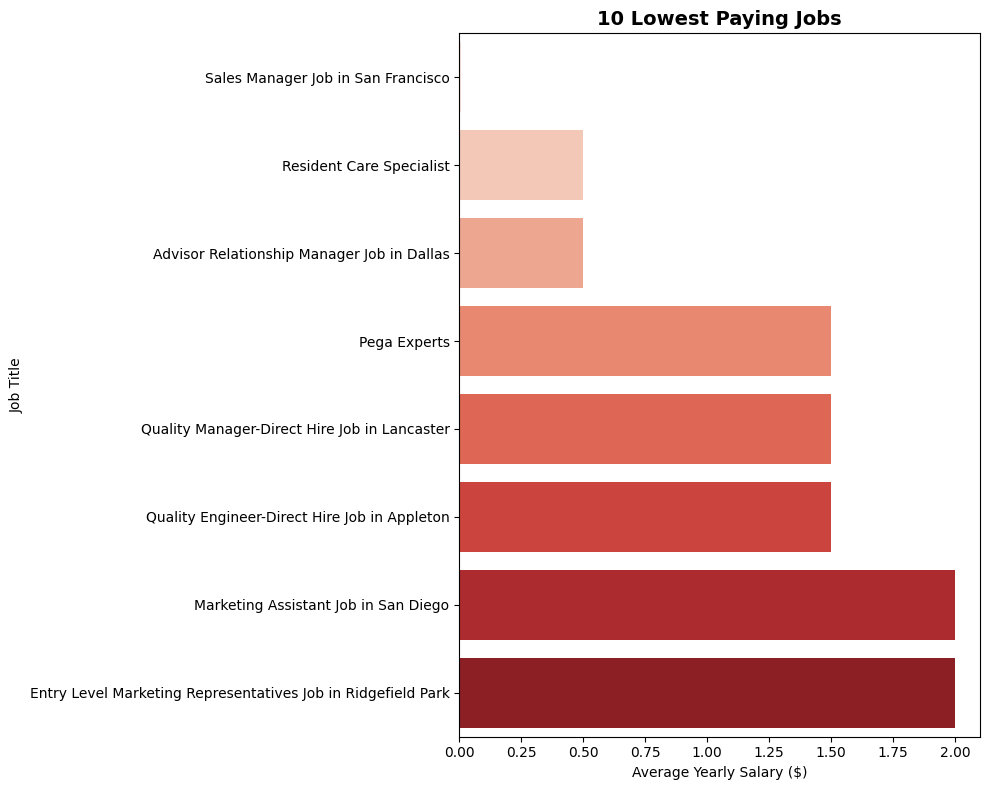

In [235]:

# Step 1: Compute average salary for each job
df['avg_salary'] = df[['min_salary_yearly', 'max_salary_yearly']].mean(axis=1)

# Step 2: Drop rows where avg_salary is missing
df_salary_clean = df.dropna(subset=['avg_salary'])

# Step 3: Get 10 lowest average salaries
lowest_salaries = df_salary_clean.nsmallest(10, 'avg_salary')

# Step 4: Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=lowest_salaries, x='avg_salary', y='job_title', palette='Reds', hue = 'job_title', legend= False)
plt.xlabel("Average Yearly Salary ($)")
plt.ylabel("Job Title")
plt.title("10 Lowest Paying Jobs", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()


The lowest paying jobs are

**Reviewer Notes:**

- This markdown section is very short; expand it to explain **methodology** or findings.
- The more context you provide, the easier it is for someone to follow your reasoning.

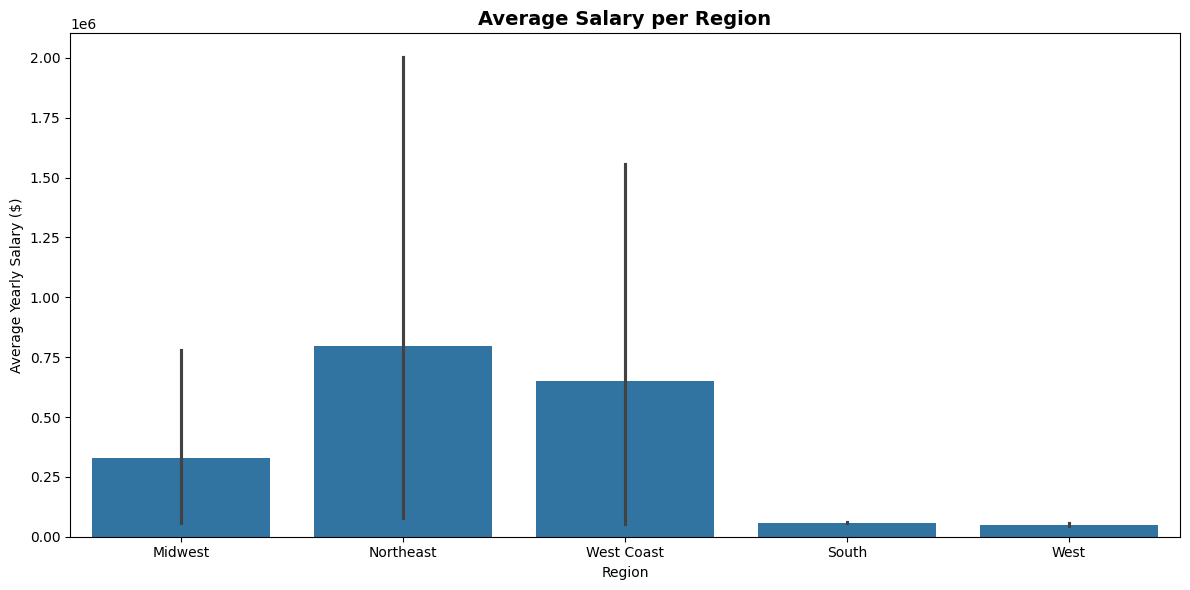

In [236]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='region', y='avg_salary')
plt.xlabel("Region")
plt.ylabel("Average Yearly Salary ($)")
plt.title("Average Salary per Region", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

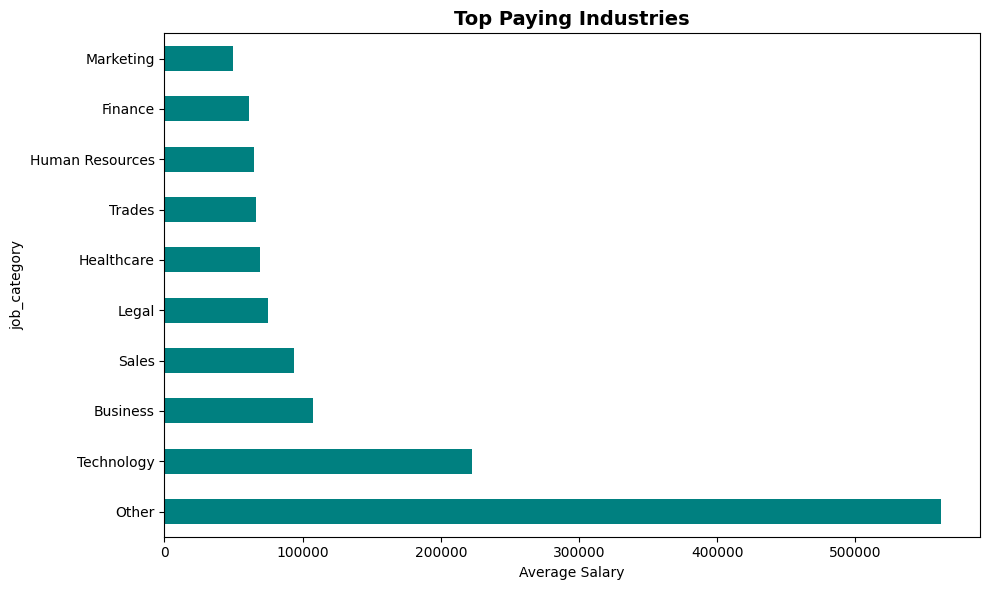

In [237]:
top_industries = df.groupby('job_category')['avg_salary'].mean().sort_values(ascending=False).head(10)
top_industries.plot(kind='barh', figsize=(10,6), color='teal')
plt.title("Top Paying Industries", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Average Salary")
plt.tight_layout()
plt.show()

**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

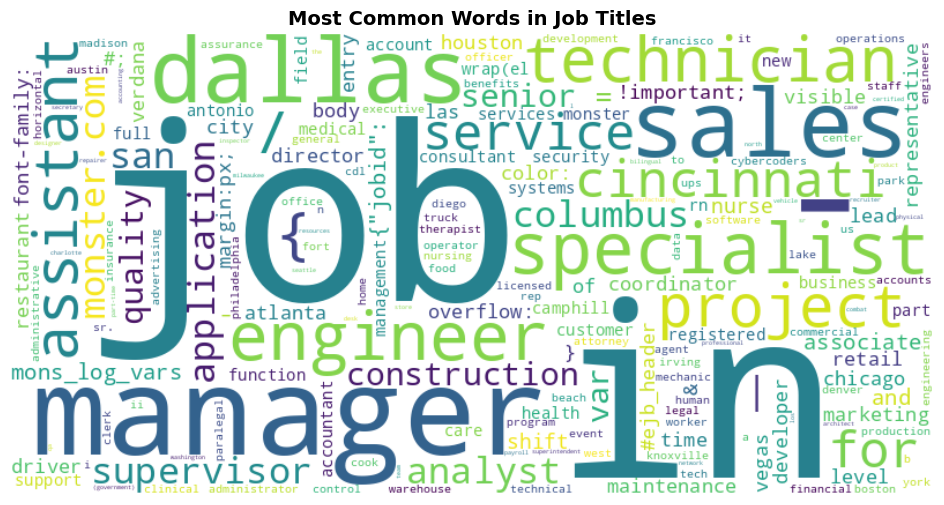

In [238]:
word_freq = Counter(" ".join(df['job_title'].dropna()).lower().split())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Job Titles", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

**Reviewer Notes:**

- This code cell has no comments. Always explain **why** you're doing something, not just what.
- Employers looking at your notebook want to see **thought process**.
- Add markdown cells before complex code to explain the logic.

In [239]:
df['salary_range'] = df['max_salary_yearly'] - df['min_salary_yearly']

In [240]:

# Select numeric features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Focus on correlation with avg_salary
salary_corr = correlation_matrix['avg_salary'].sort_values(ascending=False)

# Display top 10 most correlated features
print(salary_corr.head(10))


avg_salary           1.000000
max_salary_yearly    0.995466
salary_bin           0.995465
min_salary_yearly    0.992948
salary_range         0.722341
salary_min           0.027781
salary_max           0.021042
Name: avg_salary, dtype: float64


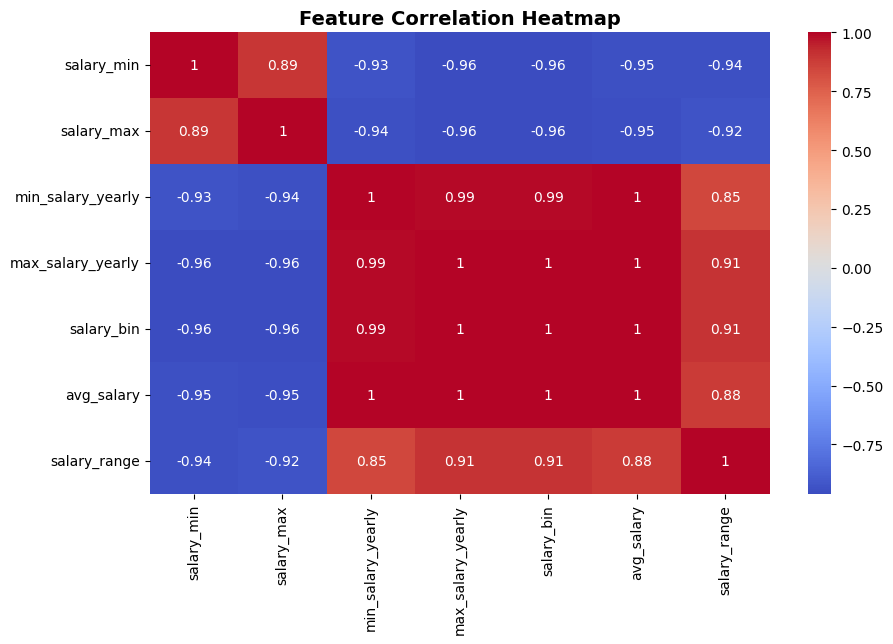

In [241]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

/tmp/ipython-input-2428658238.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skill_series.values, y=skill_series.index, palette="rocket")


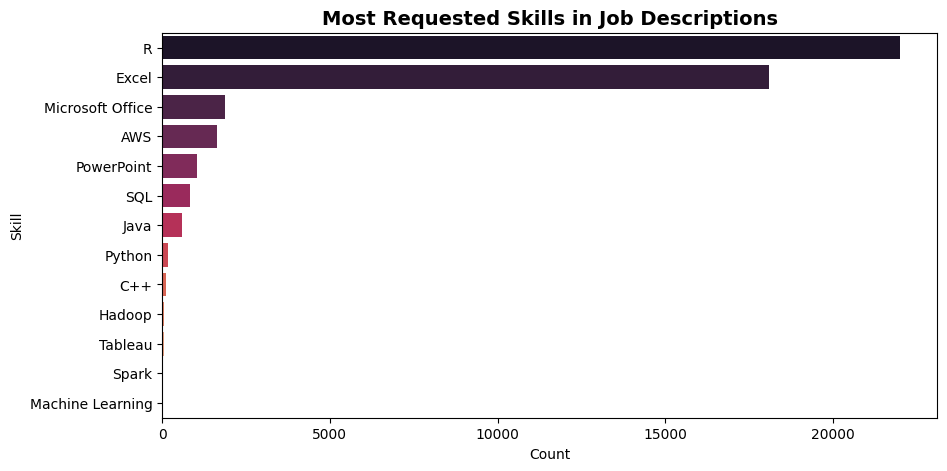

In [242]:
skills = ["Python","SQL","Excel","Tableau","R","Machine Learning","AWS","Java","C++","Hadoop","Spark", "Microsoft Office", "Excel", "PowerPoint"]
skill_counts = Counter()

for desc in df['job_description'].dropna():
    for skill in skills:
        if skill.lower() in desc.lower():
            skill_counts[skill] += 1

skill_series = pd.Series(skill_counts).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=skill_series.values, y=skill_series.index, palette="rocket")
plt.title("Most Requested Skills in Job Descriptions", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Count")
plt.ylabel("Skill")
plt.show()

# Model Creation

In [243]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
